In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import matplotlib
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

from matplotlib.collections import LineCollection

import colorcet as cc

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi_coupling.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

INFO: Read: ../data/command/japan_command_cmi_coupling.json - celeri.celeri:get_logger:7560 - 2024-11-23 22:10:59
INFO: RUN_NAME: 0000000612 - celeri.celeri:get_logger:7561 - 2024-11-23 22:10:59
INFO: Write log file: ../runs/0000000612/0000000612.log - celeri.celeri:get_logger:7562 - 2024-11-23 22:10:59
INFO: Reading data files - celeri.celeri:read_data:451 - 2024-11-23 22:10:59
SUCCESS: Read: ../data/segment/qp_japan_segment.csv - celeri.celeri:read_data:455 - 2024-11-23 22:10:59
SUCCESS: Read: ../data/block/japan_block.csv - celeri.celeri:read_data:460 - 2024-11-23 22:10:59
SUCCESS: Read: ../data/mesh/japan_mesh_parameters_cmi_coupling.json - celeri.celeri:read_data:467 - 2024-11-23 22:10:59

SUCCESS: Read: ../data/mesh/nankai.msh - celeri.celeri:read_mesh:446 - 2024-11-23 22:11:00

SUCCESS: Read: ../data/mesh/japan.msh - celeri.celeri:read_mesh:446 - 2024-11-23 22:11:00

SUCCESS: Read: ../data/mesh/sagami.msh - celeri.celeri:read_mesh:446 - 2024-11-23 22:11:00

SUCCESS: Read: ../dat

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

# Get rotation to TDE kinematic slip rate operator for all meshes tied to segments
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

INFO: Computing elastic operators - celeri.celeri:get_elastic_operators:2053 - 2024-11-23 22:11:00


Calculating Okada partials for segments: 100%|██████████| 481/481 [00:04<00:00, 116.65it/s]


INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-23 22:11:04


Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:05<00:00, 349.74it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-23 22:11:09
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-23 22:11:09


Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:08<00:00, 324.58it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-23 22:11:18
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-23 22:11:18


Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:00<00:00, 356.55it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-23 22:11:18
INFO: Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh - celeri.celeri:get_elastic_operators:2061 - 2024-11-23 22:11:18


Calculating cutde partials for triangles: 100%|██████████| 76/76 [00:00<00:00, 358.47it/s]


SUCCESS: Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh - celeri.celeri:get_elastic_operators:2067 - 2024-11-23 22:11:18
INFO: No slip rate constraints - celeri.celeri:get_slip_rate_constraints:3356 - 2024-11-23 22:11:19
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-23 22:11:19
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-11-23 22:11:20
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-23 22:11:20
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-11-23 22:11:23
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-11-23 22:11:23
SUCCESS: Finish: 

# Solve bounded KL+QP problem

In [5]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

INFO: No hard slip rate bounds - celeri.celeri:get_slip_rate_bounds:4153 - 2024-11-23 22:11:23
     pcost       dcost       gap    pres   dres
 0: -2.9506e+04 -2.9872e+07  3e+07  5e-17  2e-15
 1: -4.3939e+04 -7.2012e+06  7e+06  2e-16  7e-16
 2: -4.3712e+04 -6.7968e+06  7e+06  3e-16  8e-16
 3: -4.4926e+04 -1.1108e+06  1e+06  2e-16  9e-16
 4: -4.7548e+04 -2.1987e+05  2e+05  2e-16  7e-16
 5: -4.9542e+04 -7.0844e+04  2e+04  2e-16  7e-16
 6: -5.0288e+04 -5.3062e+04  3e+03  2e-16  8e-16
 7: -5.0475e+04 -5.1019e+04  5e+02  3e-16  8e-16
 8: -5.0517e+04 -5.0794e+04  3e+02  3e-16  6e-16
 9: -5.0529e+04 -5.0698e+04  2e+02  3e-16  5e-16
10: -5.0533e+04 -5.0652e+04  1e+02  3e-16  4e-16
11: -5.0536e+04 -5.0591e+04  5e+01  3e-16  5e-16
12: -5.0537e+04 -5.0570e+04  3e+01  3e-16  4e-16
13: -5.0538e+04 -5.0550e+04  1e+01  3e-16  5e-16
14: -5.0538e+04 -5.0544e+04  6e+00  3e-16  6e-16
15: -5.0538e+04 -5.0541e+04  3e+00  3e-16  5e-16
16: -5.0538e+04 -5.0539e+04  7e-01  3e-16  4e-16
17: -5.0538e+04 -5.0538e

# Plot KL+QP estimation

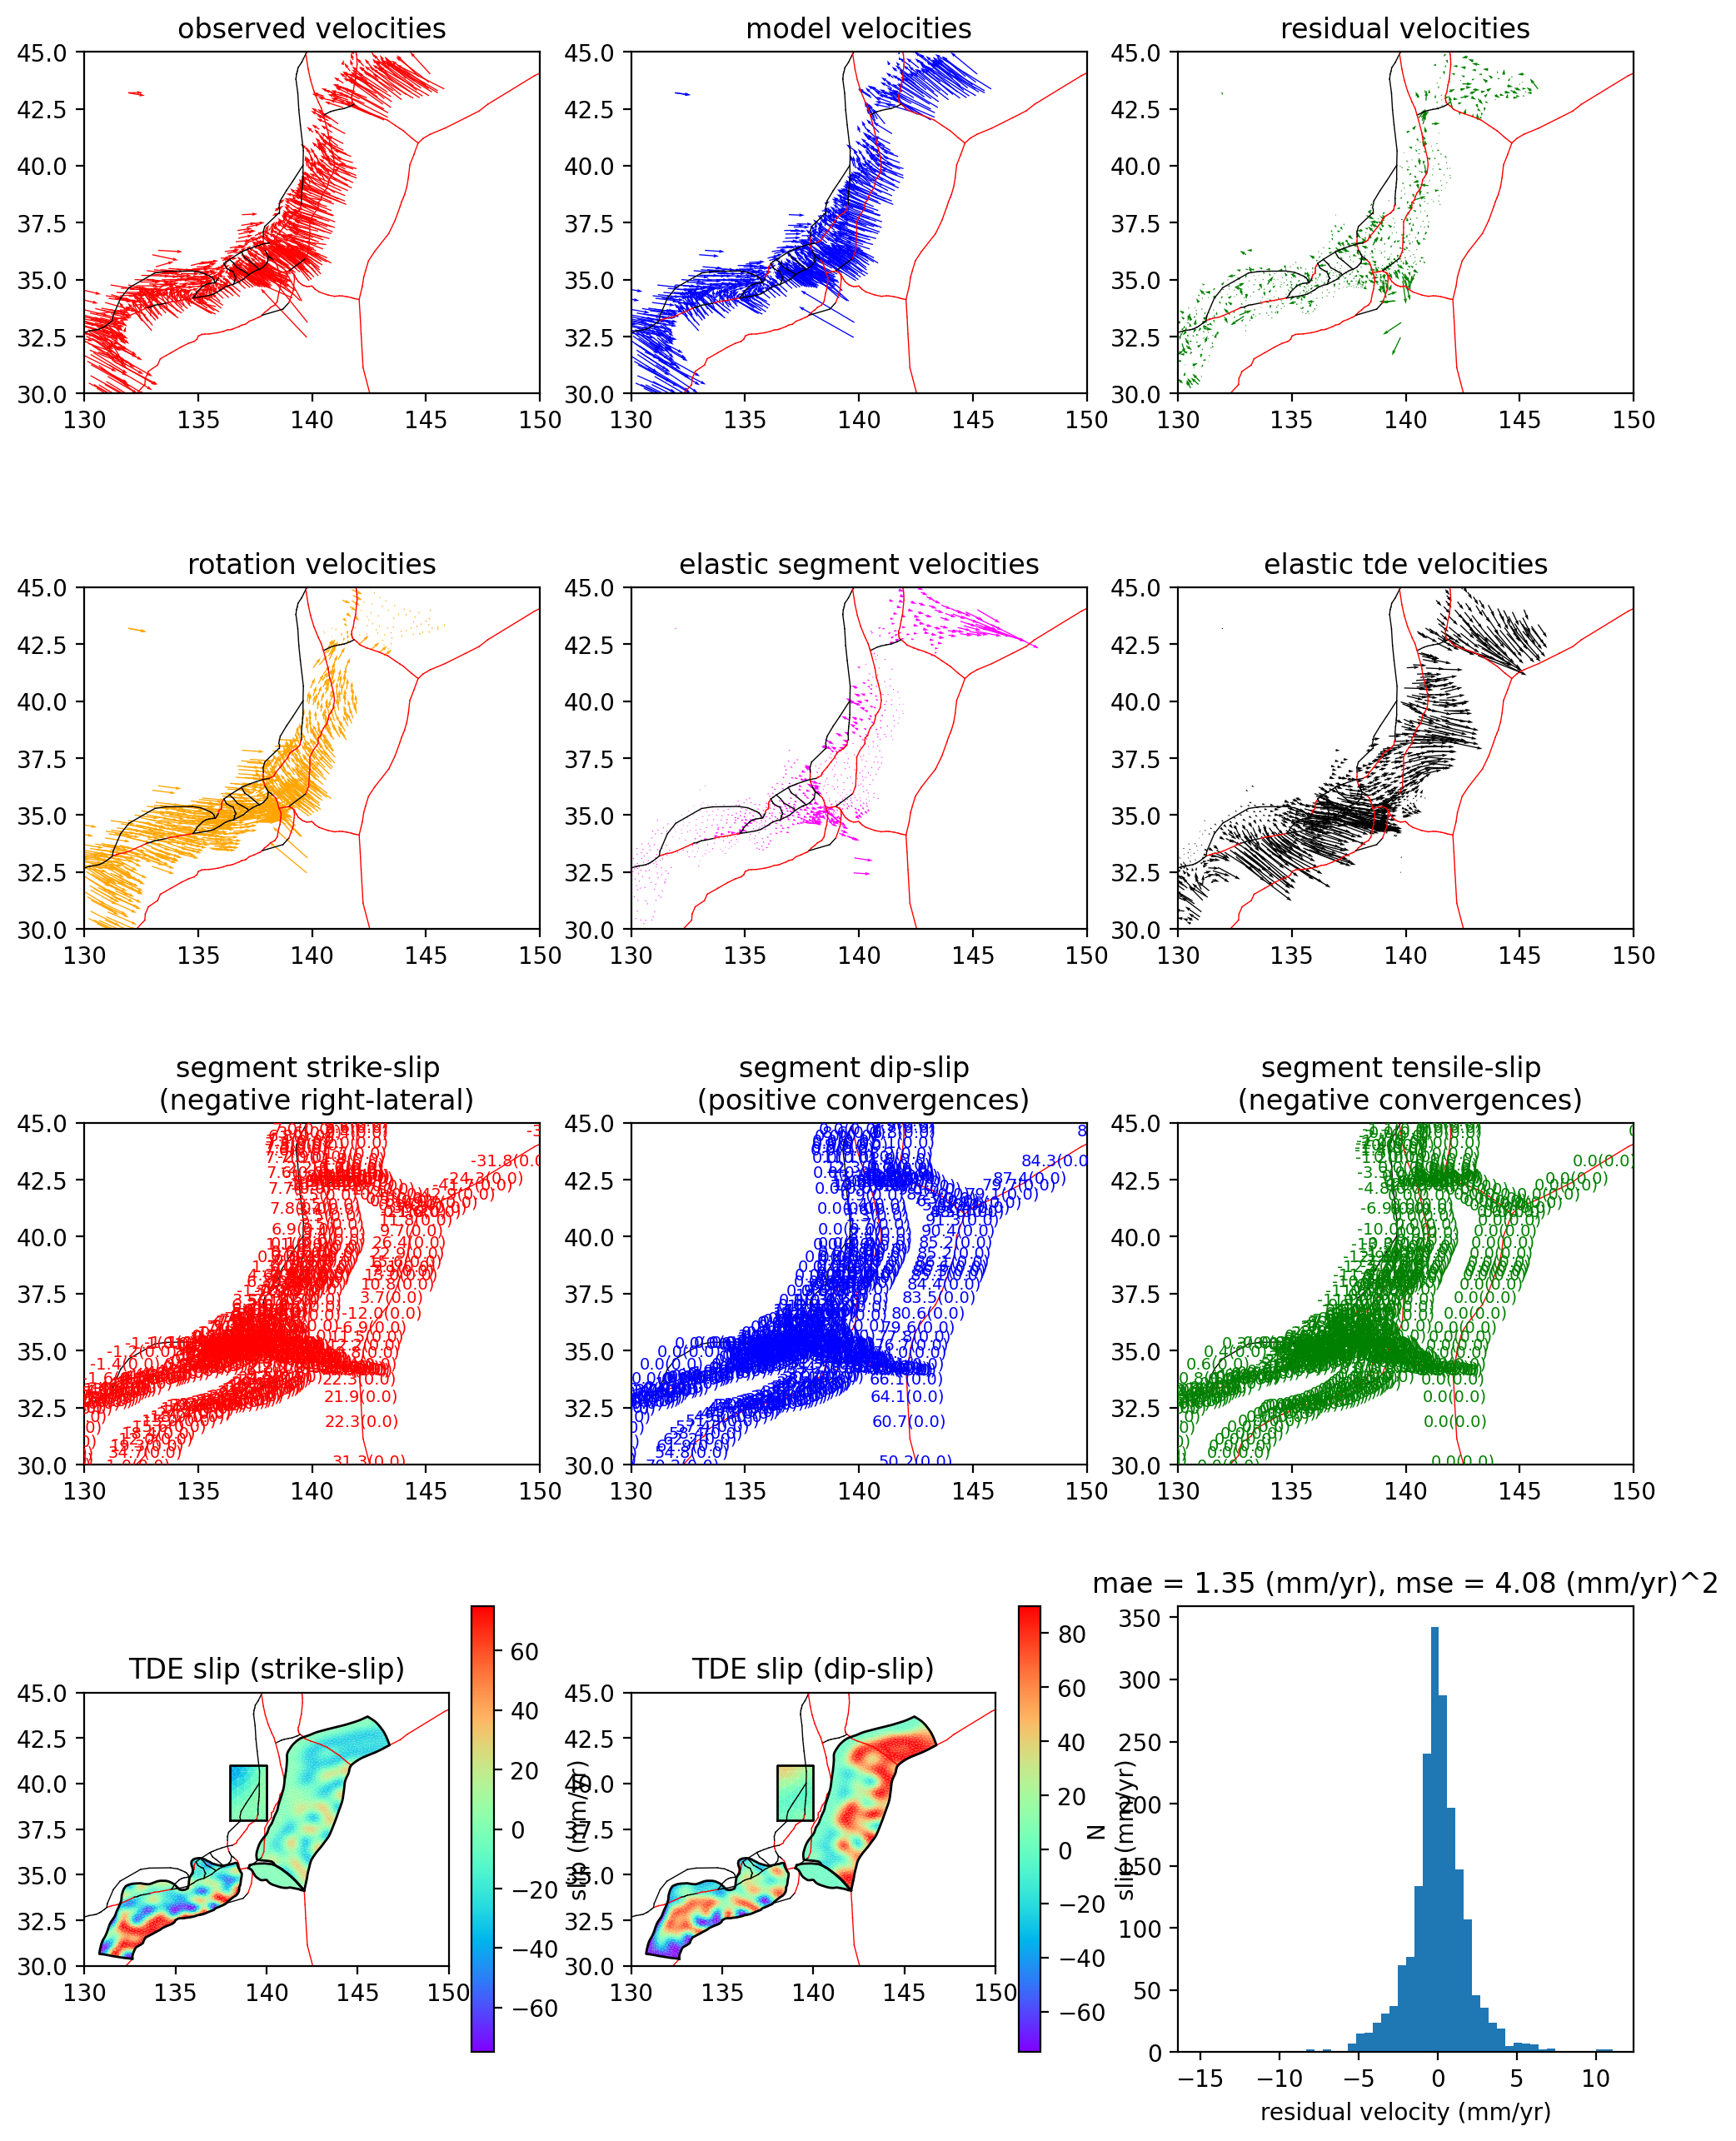

SUCCESS: Wrote figures../runs/0000000612/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6601 - 2024-11-23 22:11:29


<Figure size 640x480 with 0 Axes>

In [6]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [7]:
# Multiply rotation vector components by TDE slip rate partials
jpl = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix
bjm = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[
        3 * len(block) : 3 * len(block)
        + (meshes[0].n_modes_strike_slip + meshes[0].n_modes_dip_slip)
    ]
)


def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)
    plt.gca().set_aspect("equal")

# Correct coupling calculation

In [8]:
def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values


def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified between (x, y) points by a third value.

    It does this by creating a collection of line segments between each pair of
    neighboring points. The color of each segment is determined by the
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should have a size one less than that of x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Check color array size (LineCollection still works, but values are unused)
    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )

    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)

    # Set the values used for colormapping
    lc.set_array(c)

    return ax.add_collection(lc)


# Smooth kinematic smooth
jpl_ss_smooth = smooth_irregular_data(
    meshes[0].lon_centroid, meshes[0].lat_centroid, jpl[0::2], length_scale=0.01
)

jpl_ds_smooth = smooth_irregular_data(
    meshes[0].lon_centroid, meshes[0].lat_centroid, jpl[1::2], length_scale=0.01
)

coupling_ss = bjm[0::2] / jpl_ss_smooth

# Iterative approach to finding a solution within coupling bounds

In [9]:
# def get_coupling():
#     """
#     Function to calculate coupling
#     """


def check_coupling_bounds_single_mesh(
    meshes,
    mesh_idx,
    estimation_qp,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
    debug_plot=False,
):
    """
    *mesh_parameter.json variable names for reference:

    TDE rate bounds:
    "qp_mesh_tde_bound": 1,
    "qp_mesh_tde_slip_rate_lower_bound_ss": -30,
    "qp_mesh_tde_slip_rate_upper_bound_ss": 30,
    "qp_mesh_tde_slip_rate_lower_bound_ds": 0,
    "qp_mesh_tde_slip_rate_upper_bound_ds": 60,

    TDE coupling bounds:
    "qp_mesh_tde_bound_coupling": 0,
    "qp_mesh_tde_slip_rate_lower_bound_ss_coupling": -0.5,
    "qp_mesh_tde_slip_rate_upper_bound_ss_coupling": 0.5,
    "qp_mesh_tde_slip_rate_lower_bound_ds_coupling": 0,
    "qp_mesh_tde_slip_rate_upper_bound_ds_coupling": 1,
    """

    # Get kinematic rates on mesh elements
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Get estimated elastic rates on mesh elements
    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            3 * len(block) : 3 * len(block)
            + (meshes[mesh_idx].n_modes_strike_slip + meshes[mesh_idx].n_modes_dip_slip)
        ]
    )

    # Smooth kinematic rates
    SMOOTHING_LENGTH_SCALE = 0.1
    kinematic_tde_rates_ss_smooth = smooth_irregular_data(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        kinematic_tde_rates[0::2],
        length_scale=SMOOTHING_LENGTH_SCALE,
    )
    kinematic_tde_rates_ds_smooth = smooth_irregular_data(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        kinematic_tde_rates[1::2],
        length_scale=SMOOTHING_LENGTH_SCALE,
    )

    # Set the minimum value of the kinematic rates
    # The purpose of this is to prevent coupling blow up as the kinematic
    # rates approach zero
    MINIMUM_KINEMATIC_VELOCITY = 5.0  # mm/yr
    kinematic_tde_rates_ss_smooth[
        np.abs(kinematic_tde_rates_ss_smooth) < MINIMUM_KINEMATIC_VELOCITY
    ] = MINIMUM_KINEMATIC_VELOCITY * np.sign(
        kinematic_tde_rates_ss_smooth[
            np.abs(kinematic_tde_rates_ss_smooth) < MINIMUM_KINEMATIC_VELOCITY
        ]
    )

    kinematic_tde_rates_ds_smooth[
        np.abs(kinematic_tde_rates_ds_smooth) < MINIMUM_KINEMATIC_VELOCITY
    ] = MINIMUM_KINEMATIC_VELOCITY * np.sign(
        kinematic_tde_rates_ds_smooth[
            np.abs(kinematic_tde_rates_ds_smooth) < MINIMUM_KINEMATIC_VELOCITY
        ]
    )

    # Calculate strike-slip and dip-slip coupling
    tde_coupling_ss = estimated_tde_rates[0::2] / kinematic_tde_rates_ss_smooth
    tde_coupling_ds = estimated_tde_rates[1::2] / kinematic_tde_rates_ds_smooth

    # Plot strike-slip coupling sign
    if debug_plot == True:
        plt.figure()
        neg_coup_idx = np.where(tde_coupling_ds < 0)[0]
        pos_coup_idx = np.where(tde_coupling_ds > 0)[0]
        plt.plot(
            kinematic_tde_rates_ds_smooth[neg_coup_idx],
            estimated_tde_rates[1::2][neg_coup_idx],
            "b.",
            label="negative",
        )
        plt.plot(
            kinematic_tde_rates_ds_smooth[pos_coup_idx],
            estimated_tde_rates[1::2][pos_coup_idx],
            "r.",
            label="positive",
        )
        plt.legend()
        plt.title("dip-slip")
        plt.show()

    # Find OOB indices
    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]

    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]

    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    if debug_plot == True:
        plt.figure()
        plt.plot(
            kinematic_tde_rates_ds_smooth[tde_coupling_ds_lower_oob_idx],
            estimated_tde_rates[1::2][tde_coupling_ds_lower_oob_idx],
            "b.",
            label="OOB lower",
        )
        plt.plot(
            kinematic_tde_rates_ds_smooth[tde_coupling_ds_upper_oob_idx],
            estimated_tde_rates[1::2][tde_coupling_ds_upper_oob_idx],
            "r.",
            label="OOB upper",
        )
        plt.legend()
        plt.title("dip-slip")
        plt.show()

    # Make vectors for update slip rates (not neccesary but useful for debugging)
    updated_ss_bounds_lower = np.copy(current_ss_bounds_lower)
    updated_ss_bounds_upper = np.copy(current_ss_bounds_upper)
    updated_ds_bounds_lower = np.copy(current_ds_bounds_lower)
    updated_ds_bounds_upper = np.copy(current_ds_bounds_upper)

    # Update slip rate bounds
    SLIP_RATE_REDUCTION_FACTOR = 0.70

    # Find indices of mesh elements with negative kinematic rate
    neg_jpl_ss_idx = np.where(kinematic_tde_rates_ss_smooth < 0)[0]
    neg_jpl_ds_idx = np.where(kinematic_tde_rates_ds_smooth < 0)[0]
    pos_jpl_ss_idx = np.where(kinematic_tde_rates_ss_smooth >= 0)[0]
    pos_jpl_ds_idx = np.where(kinematic_tde_rates_ds_smooth >= 0)[0]

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, neg_jpl_ds_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, neg_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, pos_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, pos_jpl_ds_idx
    )

    # Update slip rate bounds for negative JPL cases
    # # NOTE: Note upper and lower swap here for negative kinmatic cases (2nd and 3rd quadrants)
    # updated_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_jpl_ss] += 3.0
    # updated_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_jpl_ss] += -3.0
    # updated_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_jpl_ds] += 3.0
    # updated_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_jpl_ds] += -3.0

    # # Update slip rate bounds for positive JPL cases
    # updated_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_jpl_ss] += 3.0
    # updated_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_jpl_ss] += -3.0
    # updated_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_jpl_ds] += 3.0
    # updated_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_jpl_ds] += -3.0

    # NOTE: Note upper and lower swap here for negative kinmatic cases (2nd and 3rd quadrants)
    updated_ss_bounds_lower[
        tde_coupling_ss_upper_oob_and_neg_jpl_ss
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ss_bounds_upper[
        tde_coupling_ss_lower_oob_and_neg_jpl_ss
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_lower[
        tde_coupling_ds_upper_oob_and_neg_jpl_ds
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_upper[
        tde_coupling_ds_lower_oob_and_neg_jpl_ds
    ] *= SLIP_RATE_REDUCTION_FACTOR

    # Update slip rate bounds for positive JPL cases
    updated_ss_bounds_lower[
        tde_coupling_ss_lower_oob_and_pos_jpl_ss
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ss_bounds_upper[
        tde_coupling_ss_upper_oob_and_pos_jpl_ss
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_lower[
        tde_coupling_ds_lower_oob_and_pos_jpl_ds
    ] *= SLIP_RATE_REDUCTION_FACTOR
    updated_ds_bounds_upper[
        tde_coupling_ds_upper_oob_and_pos_jpl_ds
    ] *= SLIP_RATE_REDUCTION_FACTOR

    # Total number of OOB coupling constraints
    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )

    # Report on OOB cases
    logger.info(
        f"SS TDE COUPLING BOUNDS FOR MESH {mesh_idx}, min={meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling}, max={meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling}"
    )
    logger.info(
        f"DS TDE COUPLING BOUNDS FOR MESH {mesh_idx}, min={meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling}, max={meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling}"
    )

    # Report the number and type of coupling OOB
    logger.info(
        f"MIN SS TDE COUPLING BOUNDS FOR MESH {0}, OOB AT {len(tde_coupling_ss_lower_oob_idx)} TDEs"
    )
    logger.info(
        f"MAX SS TDE COUPLING BOUNDS FOR MESH {0}, OOB AT {len(tde_coupling_ss_upper_oob_idx)} TDEs"
    )
    logger.info(
        f"MIN DS TDE COUPLING BOUNDS FOR MESH {0}, OOB AT {len(tde_coupling_ds_lower_oob_idx)} TDEs"
    )
    logger.info(
        f"MAX DS TDE COUPLING BOUNDS FOR MESH {0}, OOB AT {len(tde_coupling_ds_upper_oob_idx)} TDEs"
    )
    logger.info(f"TOTAL TDES OOB {n_oob} TDEs")

    # Determine whether or not updating is required
    if n_oob > 0:
        continue_iterate_for_coupling_bounds = True
    else:
        continue_iterate_for_coupling_bounds = False
    logger.info(
        f"CONTINUE COUPLING RELAXATION ITERATION: {continue_iterate_for_coupling_bounds}"
    )

    if debug_plot == True:
        # Plot locations of TDEs with out of bound coupling values
        plt.figure(figsize=(11, 5))
        plt.subplot(1, 2, 1)
        plot_mesh(meshes[mesh_idx], tde_coupling_ss, plt.gca())
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ss_lower_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ss_lower_oob_idx],
            "k+",
            label="below min",
        )
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ss_upper_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ss_upper_oob_idx],
            "g+",
            label="above max",
        )
        plt.legend()
        plt.title("strike-slip coupling oob")

        plt.subplot(1, 2, 2)
        plot_mesh(meshes[mesh_idx], tde_coupling_ds, plt.gca())
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ds_lower_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ds_lower_oob_idx],
            "bx",
            label="below min",
        )
        plt.plot(
            meshes[mesh_idx].lon_centroid[tde_coupling_ds_upper_oob_idx],
            meshes[mesh_idx].lat_centroid[tde_coupling_ds_upper_oob_idx],
            "g+",
            label="above max",
        )
        plt.legend()
        plt.title("dip-slip coupling oob")
        plt.show()

        # Plot adjusted bounds on mesh
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plot_mesh(meshes[mesh_idx], updated_ss_bounds_lower, plt.gca())
        plt.title("ss adjusted lower bounds")
        plt.subplot(1, 4, 2)
        plot_mesh(meshes[mesh_idx], updated_ss_bounds_upper, plt.gca())
        plt.title("ss adjusted upper bounds")
        plt.subplot(1, 4, 3)
        plot_mesh(meshes[mesh_idx], updated_ds_bounds_lower, plt.gca())
        plt.title("ds adjusted lower bounds")
        plt.subplot(1, 4, 4)
        plot_mesh(meshes[mesh_idx], updated_ds_bounds_upper, plt.gca())
        plt.title("ds adjusted upper bounds")
        plt.show()

    return (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        estimated_tde_rates[0::2],
        estimated_tde_rates[1::2],
        n_oob,
    )

INFO: 
ITERATION 0 - __main__:<module>:33 - 2024-11-23 22:11:29
INFO: SS TDE COUPLING BOUNDS FOR MESH 0, min=-1.0, max=1.0 - __main__:check_coupling_bounds_single_mesh:250 - 2024-11-23 22:11:29
INFO: DS TDE COUPLING BOUNDS FOR MESH 0, min=-1.0, max=1.0 - __main__:check_coupling_bounds_single_mesh:253 - 2024-11-23 22:11:29
INFO: MIN SS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 557 TDEs - __main__:check_coupling_bounds_single_mesh:258 - 2024-11-23 22:11:29
INFO: MAX SS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 666 TDEs - __main__:check_coupling_bounds_single_mesh:261 - 2024-11-23 22:11:29
INFO: MIN DS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 319 TDEs - __main__:check_coupling_bounds_single_mesh:264 - 2024-11-23 22:11:29
INFO: MAX DS TDE COUPLING BOUNDS FOR MESH 0, OOB AT 666 TDEs - __main__:check_coupling_bounds_single_mesh:267 - 2024-11-23 22:11:29
INFO: TOTAL TDES OOB 2208 TDEs - __main__:check_coupling_bounds_single_mesh:270 - 2024-11-23 22:11:29
INFO: CONTINUE COUPLING RELAXATION ITERATION: 

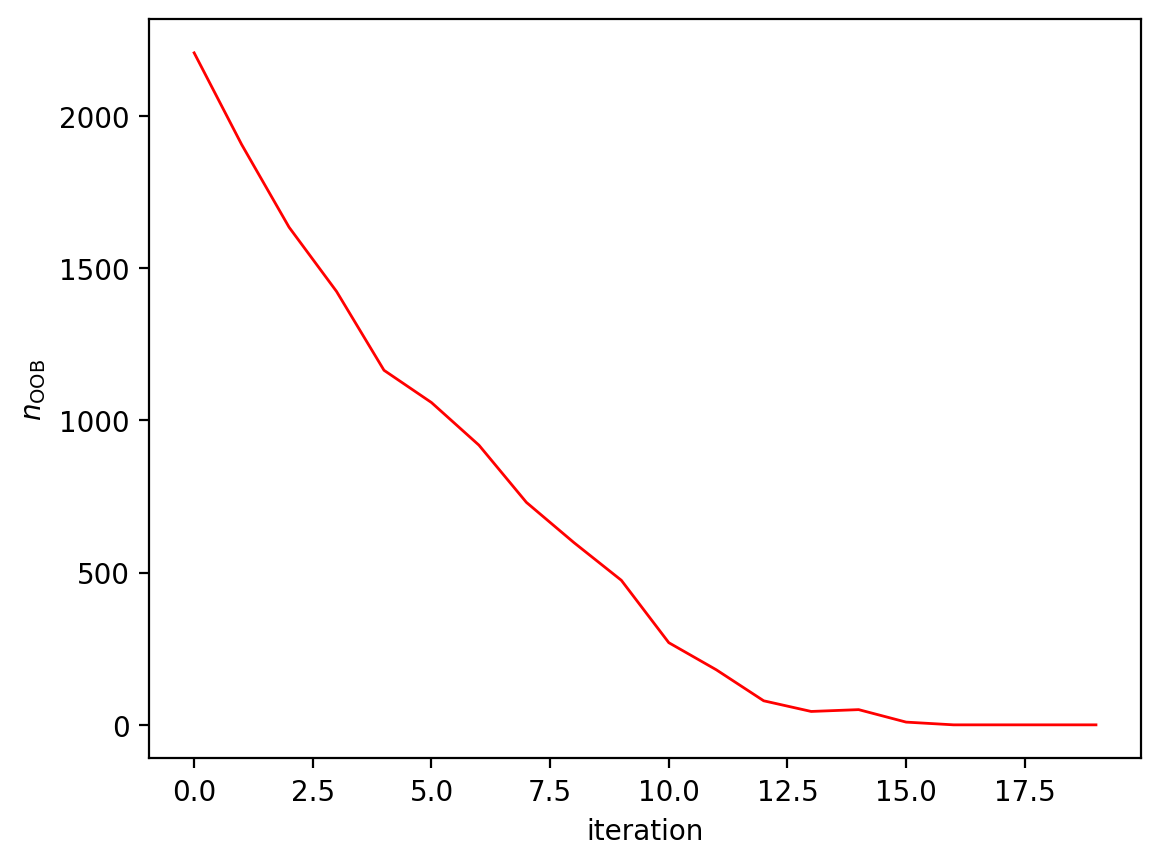

In [10]:
# Get total number of segment meshes
command.n_segment_meshes = np.max(segment.patch_file_name)

# Set tracking for each
current_ss_bounds_lower = meshes[0].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(
    meshes[0].n_tde
)
current_ss_bounds_upper = meshes[0].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(
    meshes[0].n_tde
)
current_ds_bounds_lower = meshes[0].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(
    meshes[0].n_tde
)
current_ds_bounds_upper = meshes[0].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(
    meshes[0].n_tde
)

# Start relaxation iterations
n_iter = 20
n_oob_vec = np.zeros(n_iter)
store_ss_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ss_upper = np.zeros((meshes[0].n_tde, n_iter))
store_ds_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ds_upper = np.zeros((meshes[0].n_tde, n_iter))
store_ss_jpl = np.zeros((meshes[0].n_tde, n_iter))
store_ss_bjm = np.zeros((meshes[0].n_tde, n_iter))
store_ds_jpl = np.zeros((meshes[0].n_tde, n_iter))
store_ds_bjm = np.zeros((meshes[0].n_tde, n_iter))


for i in range(n_iter):
    # Check bounds
    logger.info(f"\nITERATION {i}")
    (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        kinematic_tde_rates_ss,
        kinematic_tde_rates_ds,
        estimated_tde_rates_ss,
        estimated_tde_rates_ds,
        n_oob,
    ) = check_coupling_bounds_single_mesh(
        meshes,
        0,  # This is the mesh index
        estimation_qp,
        current_ss_bounds_lower,
        current_ss_bounds_upper,
        current_ds_bounds_lower,
        current_ds_bounds_upper,
        debug_plot=False,
    )
    logger.info(f"{n_oob} TDEs with out of coupling bounds")

    # Store total number of OOB elements at this iteration step
    n_oob_vec[i] = n_oob

    # Build and insert update slip rate bounds into QP inequality vector
    updated_lower_bounds = -1.0 * celeri.interleave2(
        updated_ss_bounds_lower, updated_ds_bounds_lower
    )
    updated_upper_bounds = celeri.interleave2(
        updated_ss_bounds_upper, updated_ds_bounds_upper
    )
    updated_bounds = np.hstack((updated_lower_bounds, updated_upper_bounds))

    # Insert updated bounds into data vector for ineqaulity constraints
    updated_qp_inequality_constraints_data_vector = np.copy(
        qp_inequality_constraints_data_vector
    )
    updated_qp_inequality_constraints_data_vector[0 : len(updated_bounds)] = (
        updated_bounds
    )

    # QP solve with updated TDE slip rate constraints
    solution_qp = celeri.lsqlin_qp(
        operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
        data_vector_eigen * np.sqrt(weighting_vector_eigen),
        0,
        qp_inequality_constraints_matrix,  # Inequality matrix
        updated_qp_inequality_constraints_data_vector,  # Inequality data vector
        None,
        None,
        None,
        None,
        None,
        {"show_progress": False},
    )

    # Create estimation data structure and calculate derived quantities
    estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
    estimation_qp.operator = operators.eigen
    celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)

    # Set *updated* to *current* for next iteration
    current_ss_bounds_lower = np.copy(updated_ss_bounds_lower)
    current_ss_bounds_upper = np.copy(updated_ss_bounds_upper)
    current_ds_bounds_lower = np.copy(updated_ds_bounds_lower)
    current_ds_bounds_upper = np.copy(updated_ds_bounds_upper)

    # Store values for understanding
    store_ss_lower[:, i] = current_ss_bounds_lower
    store_ss_upper[:, i] = current_ss_bounds_upper
    store_ds_lower[:, i] = current_ds_bounds_lower
    store_ds_upper[:, i] = current_ds_bounds_upper
    store_ss_bjm[:, i] = estimation_qp.tde_strike_slip_rates[0 : meshes[0].n_tde]
    store_ds_bjm[:, i] = estimation_qp.tde_dip_slip_rates[0 : meshes[0].n_tde]
    store_ss_jpl[:, i] = kinematic_tde_rates_ss
    store_ds_jpl[:, i] = kinematic_tde_rates_ds


# Plot convergence
plt.figure()
plt.plot(n_oob_vec, "-r", linewidth=1.0)
plt.xlabel("iteration")
plt.ylabel("$n_\mathrm{OOB}$")
plt.show()

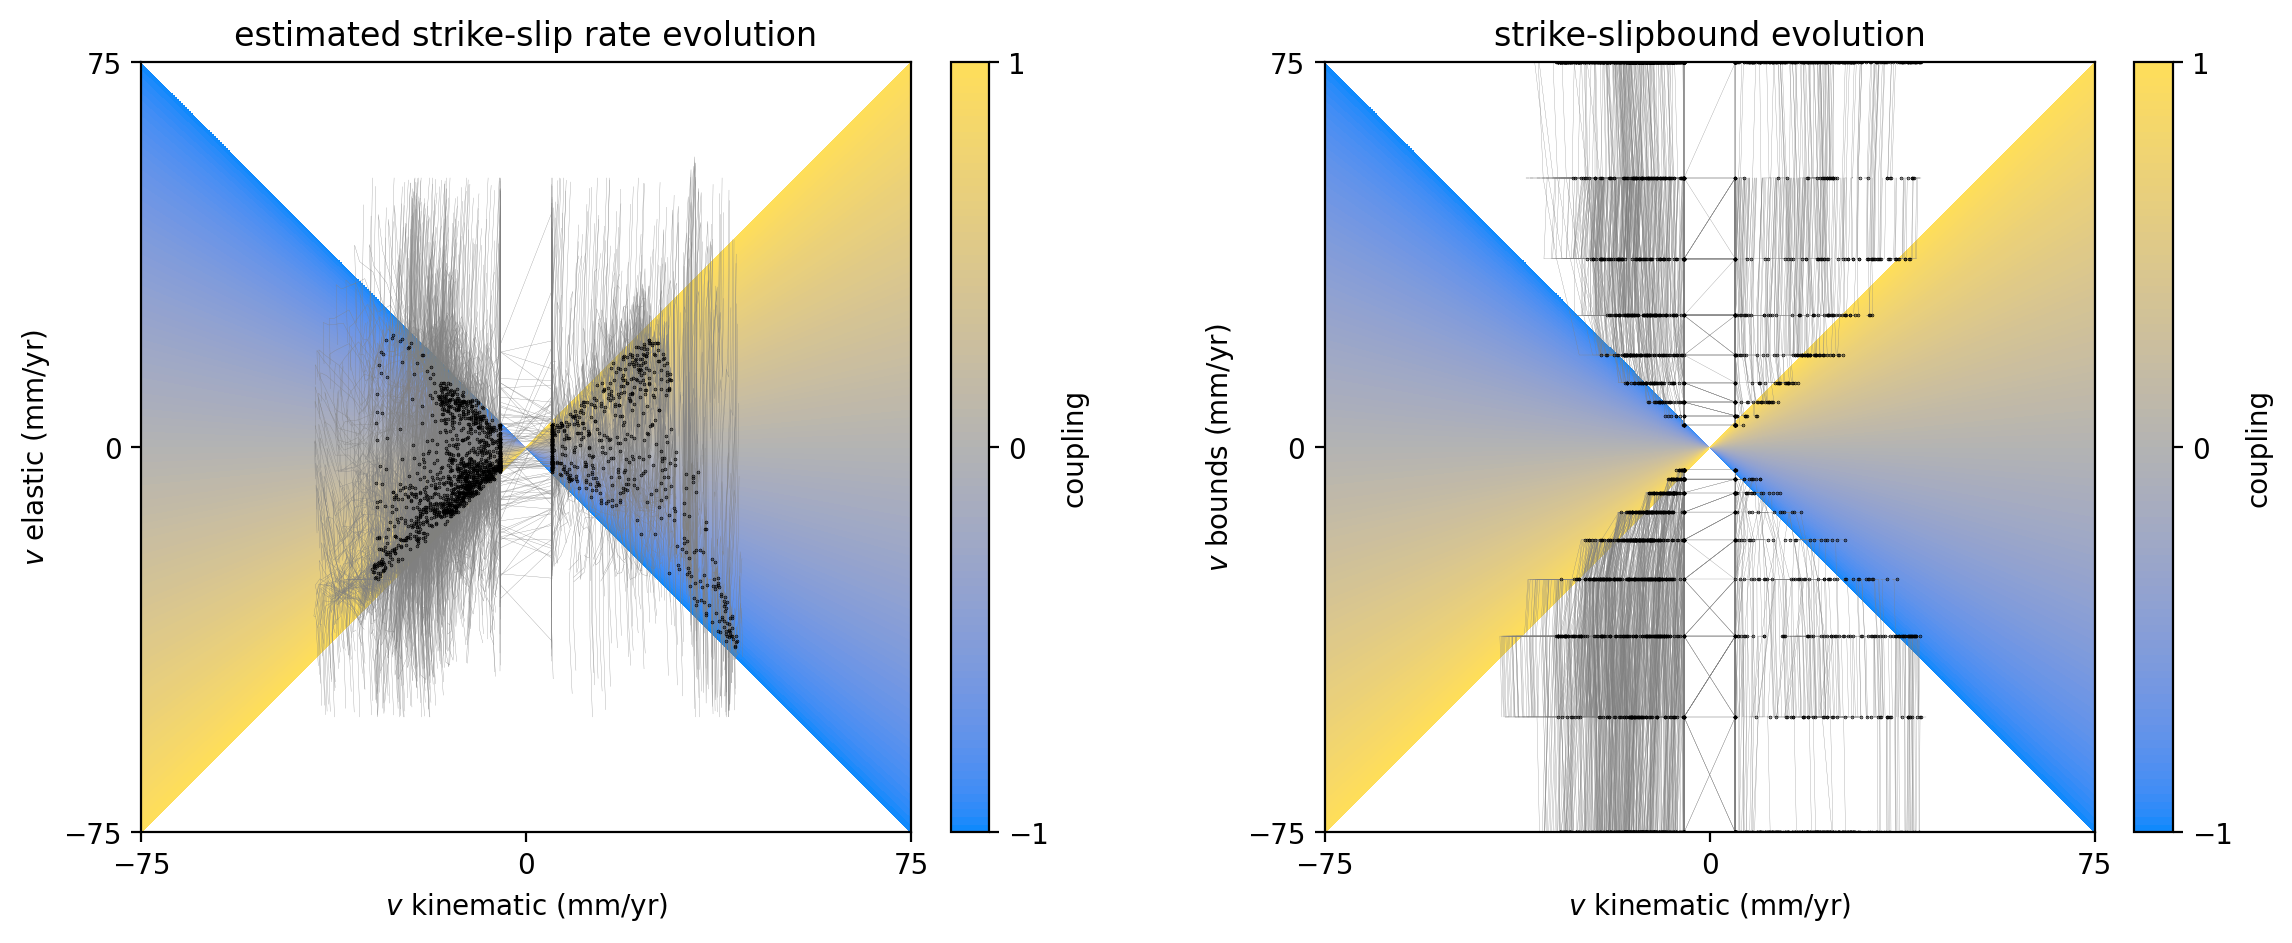

In [11]:
# iters = np.array(range(len(store_ss_jpl[0, :])))
n = meshes[0].n_tde

levels = 101
j_cutoff = 50.0
j = np.linspace(-100, 100, 1000)
b = np.linspace(-100, 100, 1000)
j_grid, b_grid = np.meshgrid(j, b)
j_grid_orig = np.copy(j_grid)
b_grid_orig = np.copy(b_grid)
coupling_grid = b_grid / (j_grid)
coupling_grid[coupling_grid > 1.0] = np.nan
coupling_grid[coupling_grid < -1.0] = np.nan

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cc.m_CET_CBD2, levels=levels)
plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])

for i in range(n):
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_bjm[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
plt.plot(store_ss_jpl[:, -1], store_ss_bjm[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ kinematic (mm/yr)")
plt.ylabel("$v$ elastic (mm/yr)")
plt.title("estimated strike-slip rate evolution")

plt.subplot(1, 2, 2)
plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cc.m_CET_CBD2, levels=levels)
plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])

for i in range(n):
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_lower[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_upper[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
plt.plot(store_ss_jpl[:, -1], store_ss_lower[:, -1], ".k", markersize=0.5)
plt.plot(store_ss_jpl[:, -1], store_ss_upper[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ kinematic (mm/yr)")
plt.ylabel("$v$ bounds (mm/yr)")
plt.title("strike-slipbound evolution")

plt.show()

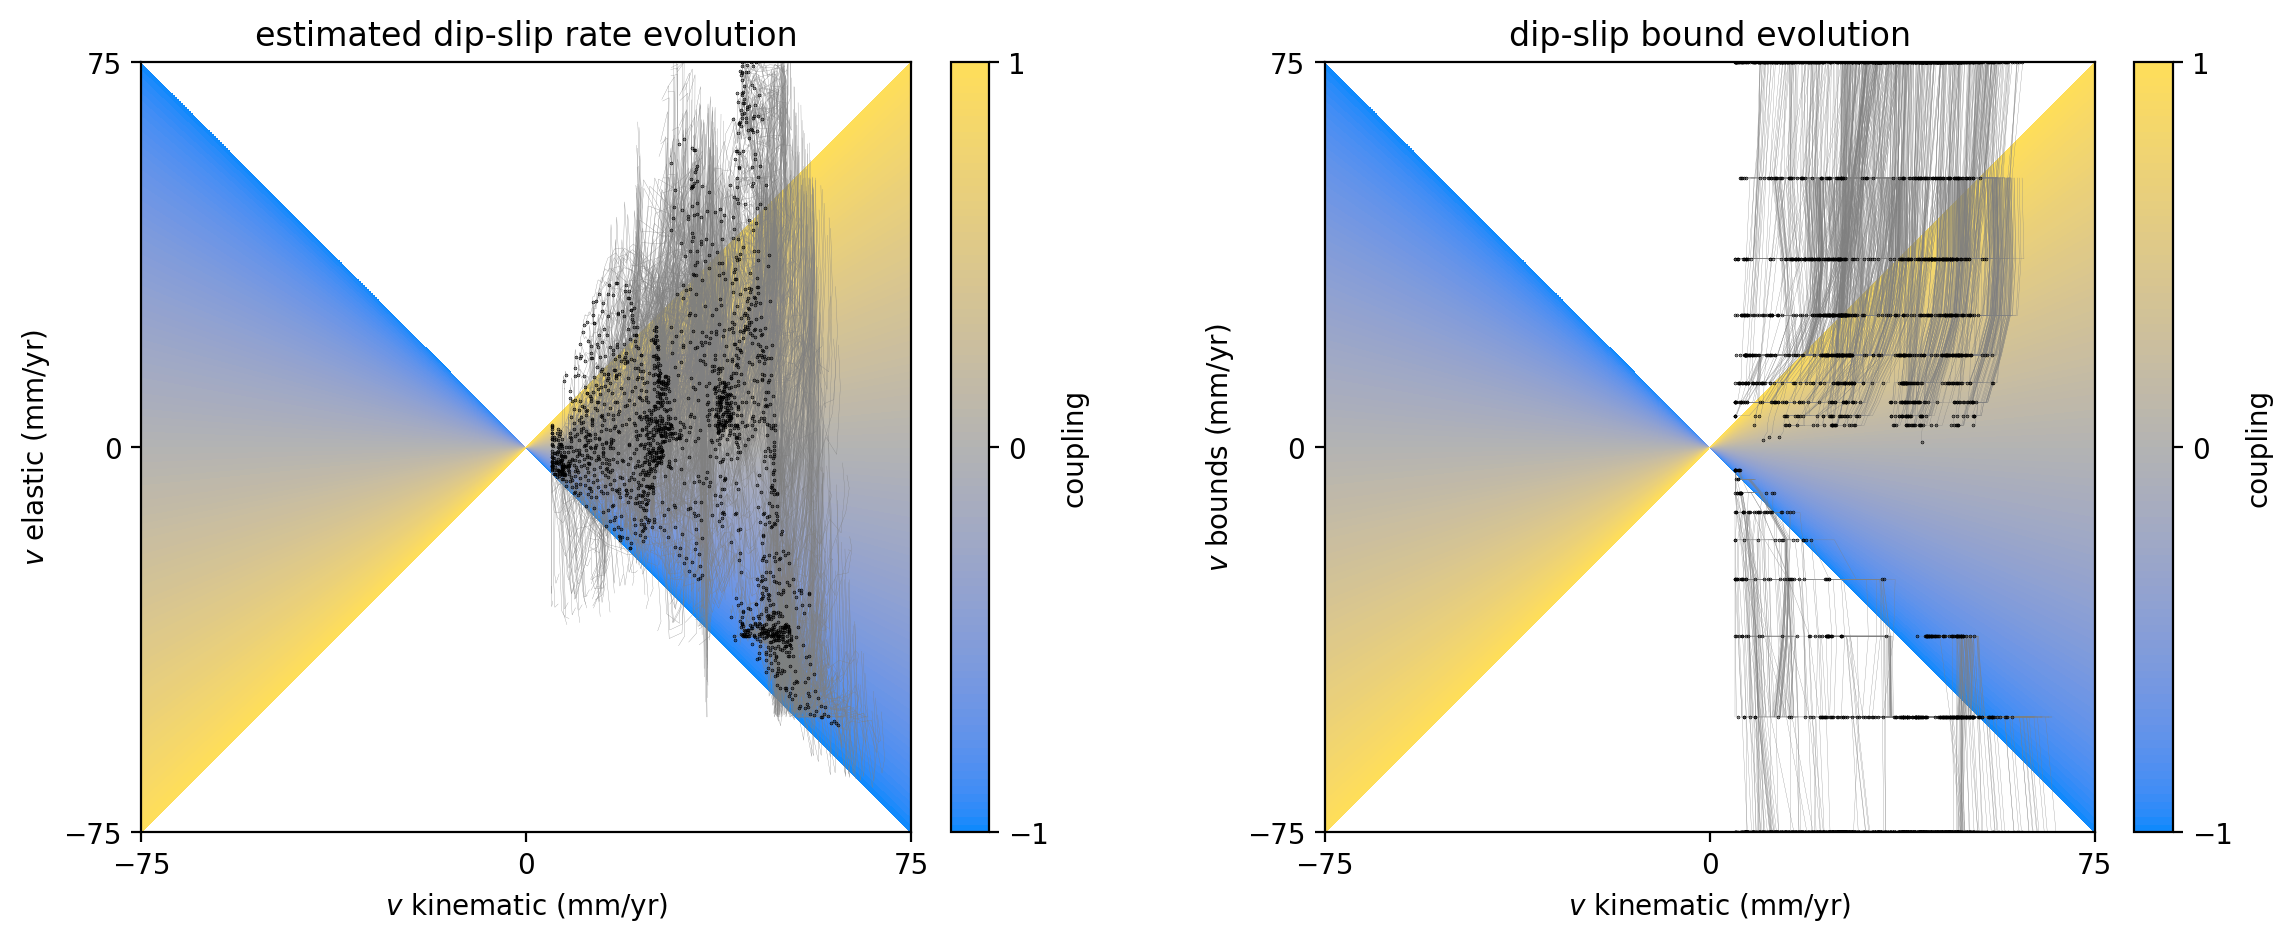

In [12]:
# iters = np.array(range(len(store_ss_jpl[0, :])))
n = meshes[0].n_tde

levels = 101
j_cutoff = 50.0
j = np.linspace(-100, 100, 1000)
b = np.linspace(-100, 100, 1000)
j_grid, b_grid = np.meshgrid(j, b)
j_grid_orig = np.copy(j_grid)
b_grid_orig = np.copy(b_grid)
coupling_grid = b_grid / (j_grid)
coupling_grid[coupling_grid > 1.0] = np.nan
coupling_grid[coupling_grid < -1.0] = np.nan

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cc.m_CET_CBD2, levels=levels)
plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])

for i in range(n):
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_bjm[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
plt.plot(store_ds_jpl[:, -1], store_ds_bjm[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ kinematic (mm/yr)")
plt.ylabel("$v$ elastic (mm/yr)")
plt.title("estimated dip-slip rate evolution")

plt.subplot(1, 2, 2)
plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cc.m_CET_CBD2, levels=levels)
plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])

for i in range(n):
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_lower[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_upper[i, :],
        "-",
        linewidth=0.1,
        color="gray",
        zorder=1,
    )
plt.plot(store_ds_jpl[:, -1], store_ds_lower[:, -1], ".k", markersize=0.5)
plt.plot(store_ds_jpl[:, -1], store_ds_upper[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ kinematic (mm/yr)")
plt.ylabel("$v$ bounds (mm/yr)")
plt.title("dip-slip bound evolution")

plt.show()

# Plot slip rate estimates vs bounds
- Check to make sure that we are always within bounds

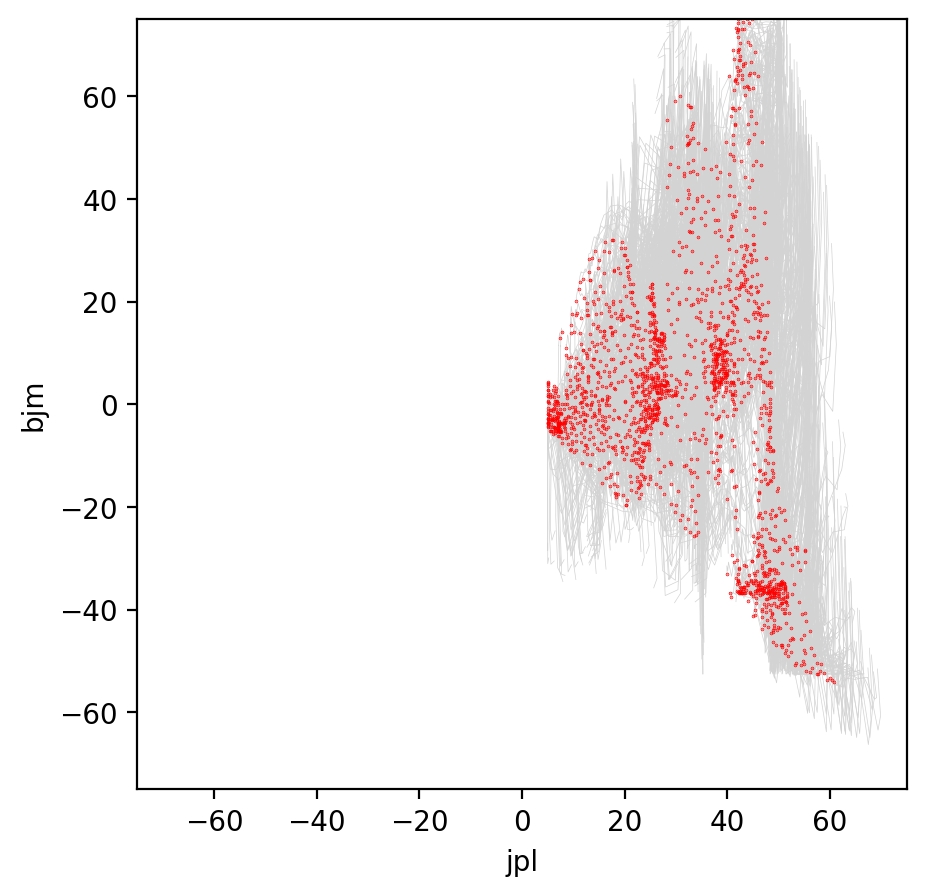

In [13]:
n = meshes[0].n_tde
plt.figure(figsize=(5, 5))
for i in range(n):
    if store_ds_bjm[i, 0] != store_ds_bjm[i, -1]:
        plt.plot(
            store_ds_jpl[i, :],
            store_ds_bjm[i, :],
            "-",
            linewidth=0.25,
            color="lightgray",
            zorder=1,
        )

plt.plot(
    store_ds_jpl[:, -1],
    store_ds_bjm[:, -1],
    "r.",
    linewidth=0.25,
    markersize=0.5,
    zorder=1,
)

plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.gca().set_aspect("equal")
plt.xlabel("jpl")
plt.ylabel("bjm")
plt.show()

# Plot complete model result after coupling iterations

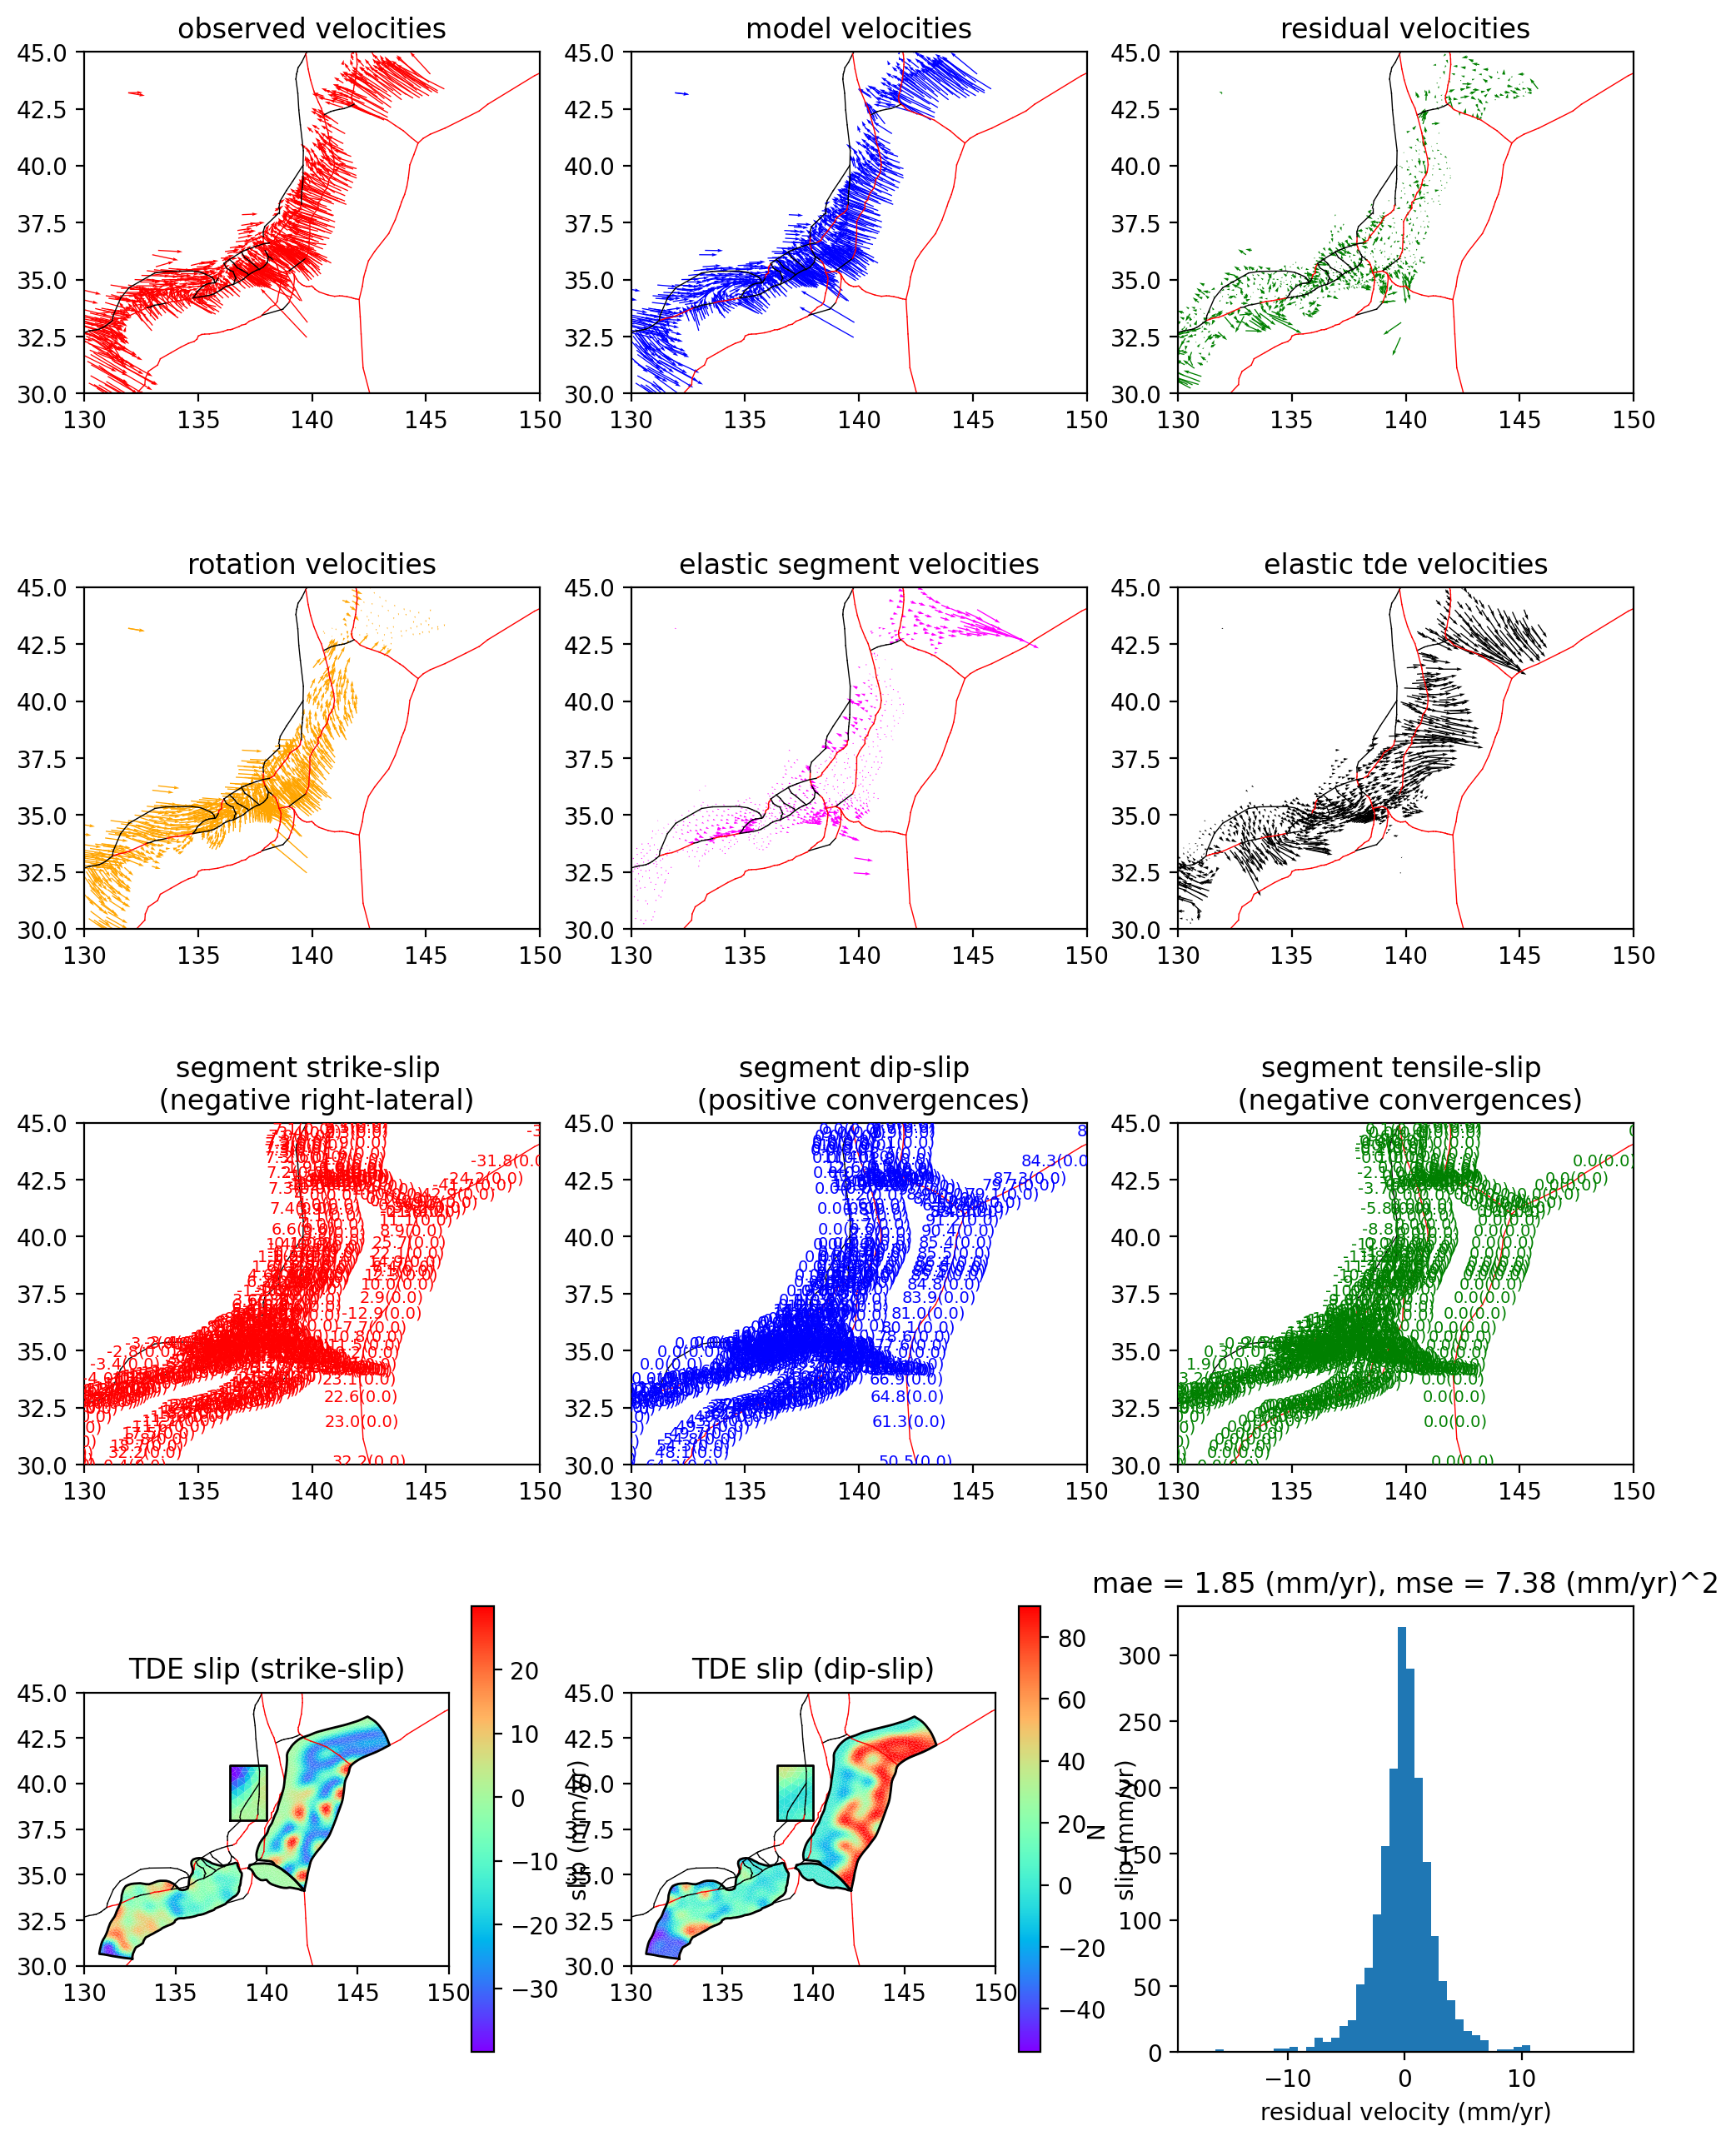

SUCCESS: Wrote figures../runs/0000000612/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6601 - 2024-11-23 22:12:04


<Figure size 640x480 with 0 Axes>

In [14]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Plot final slip rates and coupling distributions

Text(0.5, 1.0, 'strike-slip (elastic)')

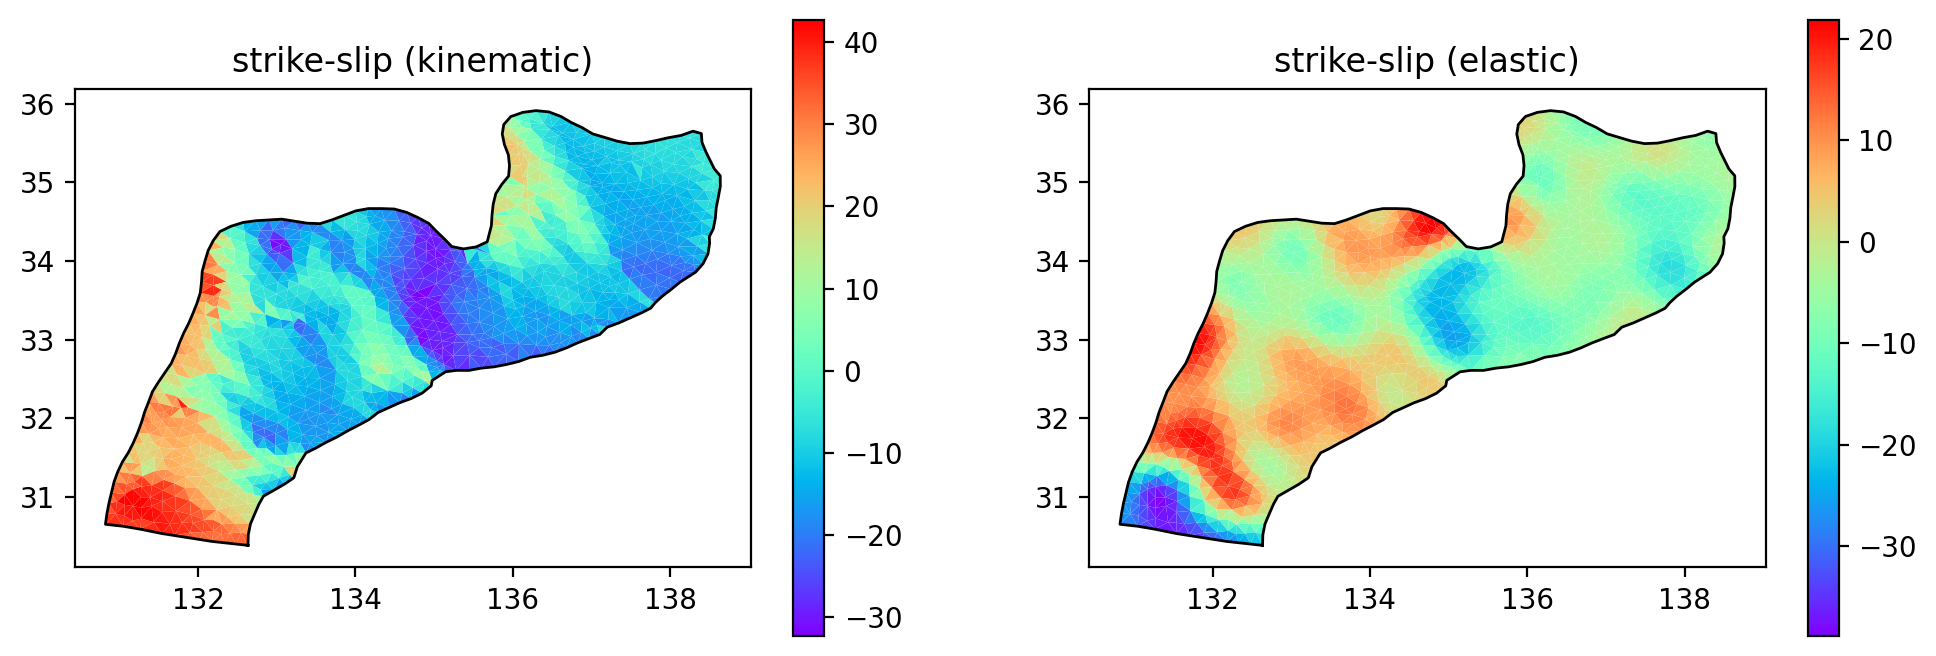

In [15]:
# Multiply rotation vector components by TDE slip rate partials
jpl = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix
bjm = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[
        3 * len(block) : 3 * len(block)
        + meshes[0].n_modes_strike_slip
        + meshes[0].n_modes_dip_slip
    ]
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_mesh(meshes[0], jpl[0::2], plt.gca())
plt.title("strike-slip (kinematic)")

plt.subplot(1, 2, 2)
plot_mesh(meshes[0], bjm[0::2], plt.gca())
plt.title("strike-slip (elastic)")

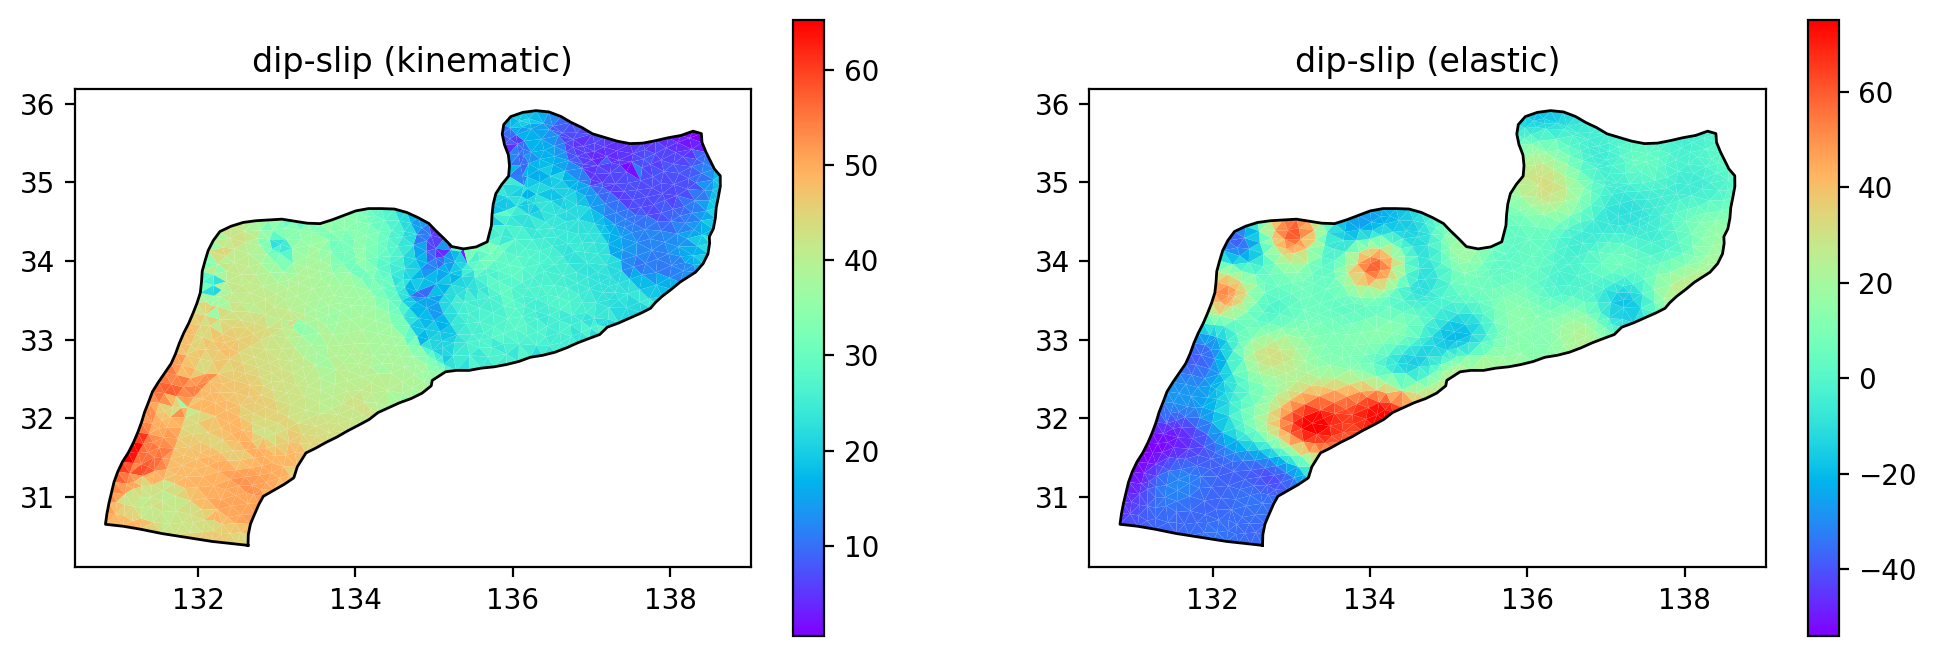

In [16]:
# Multiply rotation vector components by TDE slip rate partials
jpl = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix
bjm = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[
        3 * len(block) : 3 * len(block)
        + meshes[0].n_modes_strike_slip
        + meshes[0].n_modes_dip_slip
    ]
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_mesh(meshes[0], jpl[1::2], plt.gca())
plt.title("dip-slip (kinematic)")

plt.subplot(1, 2, 2)
plot_mesh(meshes[0], bjm[1::2], plt.gca())
plt.title("dip-slip (elastic)")
plt.show()